# ****1. Import Library yang dibutuhkan****
Sebelum mengimport library yang dibutuhkan pertama kita perlu menginstall *opencv-python ultralytics numpy* terlebih dahulu karena di google colab belum terinstall.

In [1]:
pip install opencv-python ultralytics numpy

In [2]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# ****2. Load Pre-trained Model****
Pada bagian ini ktia memuat model arsitektur YOLO versi 11 yang mendukung segmentasi objek.


In [3]:
yolo_model = YOLO("yolo11x-seg.pt")

# ****3. Load Gambar****
Kemudian OpenCV membaca file gambar dari path yang diberikan.

In [4]:
image = cv2.imread("/content/istockphoto-1468143769-612x612.jpg")

# ****4. Segmentasi Gambar****
Pada bagian ini kami melakukan segmentasi semantik pada sebuah gambar menggunakan model YOLOv11-seg, dimulai dengan mengambil daftar nama kelas dari model, lalu memprediksi objek-objek pada gambar dengan `confidence threshold` 0.3. Setiap kelas diberi warna acak, dan untuk setiap objek yang terdeteksi, area mask-nya diwarnai menggunakan `cv2.fillPoly` dan diberi label teks di tengahnya. Hasil segmentasi disimpan dalam citra `semantic_mask`, dikonversi ke format RGB, lalu ditampilkan menggunakan Matplotlib sebagai plot segmentasi semantik berwarna.



0: 384x640 1 person, 1 car, 1 motorcycle, 8168.6ms
Speed: 7.5ms preprocess, 8168.6ms inference, 16.0ms postprocess per image at shape (1, 3, 384, 640)


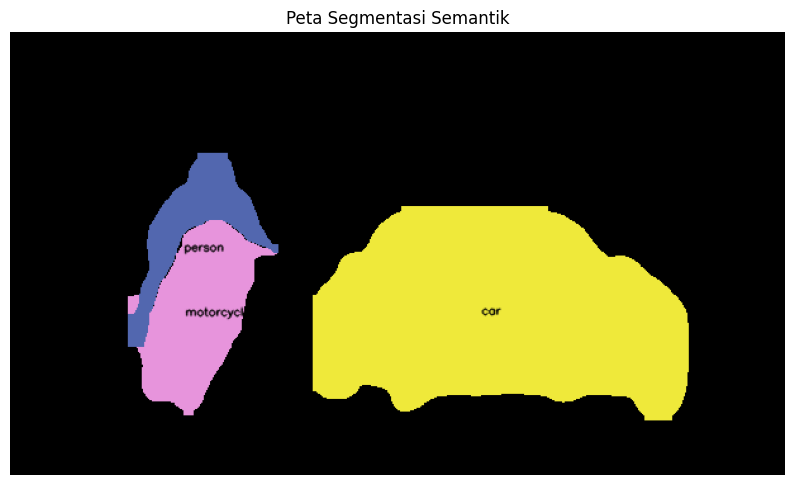

In [5]:
# Mengambil Daftar Kelas dari Model
label_names = list(yolo_model.names.values())
label_ids = [label_names.index(name) for name in label_names]

confidence_threshold = 0.3
predictions = yolo_model.predict(image, conf=confidence_threshold)

# Menyiapkan warna random untuk tiap kelas
color_palette = [random.choices(range(256), k=3) for _ in label_ids]

# Visualisasi Segmentasi
semantic_mask = np.zeros_like(image)

for pred in predictions:
    for mask, box in zip(pred.masks.xy, pred.boxes):
        class_index = int(box.cls[0])
        mask_color = color_palette[class_index]

        polygon_array = np.array(mask, dtype=np.int32)
        if polygon_array.ndim == 2:
          polygon_array = polygon_array.reshape((-1, 1, 2))

        cv2.fillPoly(semantic_mask, [polygon_array], mask_color)

        # Menghitung koordinat tengah untuk label
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2

        # Menambahkan nama kelas
        class_label = label_names[class_index]
        cv2.putText(semantic_mask, class_label, (center_x - 15, center_y + 2),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0), 1, cv2.LINE_AA)

# Tampilkan hasil segmentasi
semantic_rgb = cv2.cvtColor(semantic_mask, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(semantic_rgb)
plt.axis("off")
plt.title("Peta Segmentasi Semantik")
plt.show()

# ****5. Bounding Box + Label dengan Confidence****

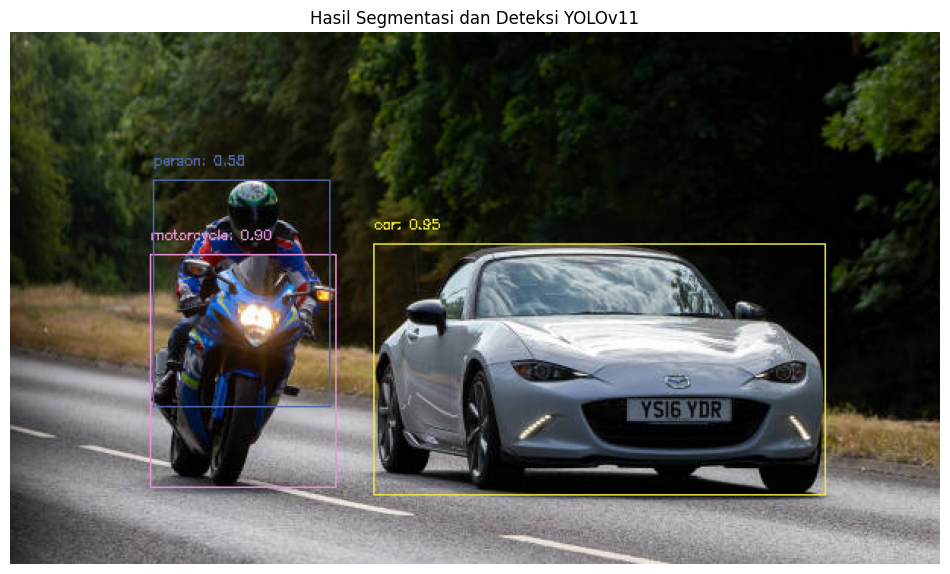

In [6]:
for pred in predictions:
    for mask, box in zip(pred.masks.xy, pred.boxes):
        class_index = int(box.cls[0])
        confidence = float(box.conf[0])
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        bbox_color = color_palette[label_ids.index(class_index)]
        label_text = f"{label_names[class_index]}: {confidence:.2f}"

        # Menggambar bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), bbox_color, 1)

        # Menambahkan label
        cv2.putText(image, label_text, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.3, bbox_color, 1)

# Konversi ke RGB dan tampilkan hasil akhir
final_output = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.imshow(final_output)
plt.axis("off")
plt.title("Hasil Segmentasi dan Deteksi YOLOv11")
plt.show()